In [1]:
import os
import numpy as np
import pandas as pd
import scipy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold
from mllib.model import KerasSurrogate
from tensorflow import keras

In [2]:
class AdjustedRSquaredSeparated(tf.keras.losses.Loss):
    '''
    Calculates the adjusted R^2 value for each predicted quantity separately.

    For more details, see:
    https://www.analyticsvidhya.com/blog/2020/07/difference-between-r-squared-and-adjusted-r-squared/
    '''
    def __init__(self, batch_size, number_of_input):
        '''
        Parameters
        ==========
        batch_size: int
            Number of samples in a batch,
            i. e. number of rows of a batch of the X matrix.
        number_of_input: int
            Number of independent variables (=columns) in the problem,
            i. e. number of columns of the X matrix.
        '''
        super().__init__(name='adjusted_r2')
        self._n = batch_size
        self._n_in = number_of_input

    def call(self, y_true, y_pred):
        r2 = RSquaredSeparated().call(y_true, y_pred)

        adjusted_r2 = 1. - (1. - r2) * (self._n - 1.) / (self._n - self._n_in - 1.)

        return adjusted_r2

    @classmethod
    def from_config(cls, config):
        return AdjustedRSquaredSeparated(config['n'], config['n_in'])

    def get_config(self):
        return {
            'n': self._n,
            'n_in': self._n_in,
        }

In [3]:
class RSquaredSeparated(tf.keras.losses.Loss):
    '''
    Calculates the R^2 value for each predicted quantity separately.

    For more details, see:
    https://www.analyticsvidhya.com/blog/2020/07/difference-between-r-squared-and-adjusted-r-squared/
    '''
    def __init__(self):
        super().__init__(name='r2')

    def call(self, y_true, y_pred):
        mean_true = tf.math.reduce_mean(y_true, axis=0)

        total_sum_of_squares = tf.math.reduce_sum(tf.math.squared_difference(y_true, mean_true),
                                                  axis=0)
        
        residual_sum_of_squares = tf.math.reduce_sum(tf.math.squared_difference(y_true, y_pred),
                                                     axis=0)
        r2 = 1. - residual_sum_of_squares / total_sum_of_squares

        return r2

In [4]:
class AdjustedRSquared(tf.keras.losses.Loss):
    '''
    For more details, see:
    https://www.analyticsvidhya.com/blog/2020/07/difference-between-r-squared-and-adjusted-r-squared/
    '''
    def __init__(self, batch_size, number_of_input):
        '''
        Parameters
        ==========
        batch_size: int
            Number of samples in a batch,
            i. e. number of rows of a batch of the X matrix.
        number_of_input: int
            Number of independent variables (=columns) in the problem,
            i. e. number of columns of the X matrix.
        '''
        super().__init__(name='adjusted_r2')
        self._n = batch_size
        self._n_in = number_of_input

    def call(self, y_true, y_pred):
        r2 = RSquared().call(y_true, y_pred)

        adjusted_r2 = 1. - (1. - r2) * (self._n - 1.) / (self._n - self._n_in - 1.)
        adjusted_r2 = tf.math.reduce_mean(adjusted_r2)

        return adjusted_r2

    @classmethod
    def from_config(cls, config):
        return AdjustedRSquared(config['n'], config['n_in'])

    def get_config(self):
        return {
            'n': self._n,
            'n_in': self._n_in,
        }

In [5]:
#wMAPE

def wmape(actual, pred):
    wMAPE = np.sum(np.abs(actual-pred))/np.sum(np.abs(actual))*100
    return wMAPE

In [6]:
seed = 1234
tf.random.set_seed(seed)
np.random.seed(seed)

# Include test data and Models

In [7]:
test_datafile_fw = '/data/project/general/aerosolretriev/aerosol_data/dataset_12_2022/preprocessed_new/data_all_test_fw1.h5'
test_datafile_iv = '/data/project/general/aerosolretriev/aerosol_data/dataset_12_2022/preprocessed_new/data_all_test_iv1.h5'



In [8]:
model_name_fw = 'forward_model/surrogate_model'
model_name_iv = 'forward_model/surrogate_model'

In [9]:
model_dir_fw = '/data/project/general/aerosolretriev/aerosol_results_december_2022/results_Romana/results_12_12_2022/forward_models_fw1/models'
model_dir_iv = '/data/project/general/aerosolretriev/aerosol_results_december_2022/results_Romana/results_12_12_2022/forward_models_iv1/models'


In [10]:
# Resulting plots will be stored in the fw model directory
plot_dir = model_dir_fw +'/plots/model'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
plot_dir

'/data/project/general/aerosolretriev/aerosol_results_december_2022/results_Romana/results_12_12_2022/forward_models_fw1/models/plots/model'

# Load the model and the data

In [11]:
custom_objects = {
    'AdjustedRSquared': AdjustedRSquared,
}

kwargs = {
    'custom_objects': custom_objects,
    'compile': False,
}

surr_fw = KerasSurrogate.load(model_dir_fw, model_name_fw, model_kwargs=kwargs)
surr_iv = KerasSurrogate.load(model_dir_iv, model_name_iv, model_kwargs=kwargs)


In [12]:
dvar_test = pd.read_hdf(test_datafile_iv,key = 'dvar')
qoi_test = pd.read_hdf(test_datafile_iv,key = 'qoi')

# I just include the test_datafile_iv, because it should be the same as test_datafile_fw, just dvar and qoi are switched
# In the test datafile dvar are preprocessed already with:
# log(dvar['Vtot'],dvar['RmedianV'],dvar['GSD']-1, dvar['n']-1.33,dvar['k'])
# qoi are preprocessed with log(qoi[F11])

dvar_test_preprocessed = dvar_test.copy()
qoi_test_preprocessed = qoi_test.copy()


In [13]:
#dvar_test1 = pd.read_hdf(test_datafile_fw,key = 'dvar')
#qoi_test1 = pd.read_hdf(test_datafile_fw,key = 'qoi')


# Predict aerosol properties from phase functions

In [14]:
dvar_pred = surr_fw.predict(qoi_test_preprocessed)
dvar_pred = pd.DataFrame(data=dvar_pred, columns=dvar_test.columns)

In [15]:
dvar_pred = np.exp(dvar_pred)
dvar_pred['GSD']=dvar_pred['GSD']+1
dvar_pred['n']= dvar_pred['n']+1.33

dvar_test = np.exp(dvar_test)
dvar_test['GSD']=dvar_test['GSD']+1
dvar_test['n']=dvar_test['n']+1.33

## 1.calculate metrics

In [16]:
fw_error_df = pd.DataFrame(columns = dvar_test.columns)
fw_error_df


Empty DataFrame
Columns: [Vtot, RmedianV, GSD, n, k]
Index: []

In [17]:
# R2 value
metric = AdjustedRSquaredSeparated(dvar_test.shape[0], dvar_test.shape[1])

r2_adj_fw = metric.call(dvar_test.values, dvar_pred.values).numpy()
r2_adj_fw = pd.Series(data=r2_adj_fw, index=dvar_test.columns)
r2_adj_fw = np.round(r2_adj_fw, decimals=2)
r2_adj_fw = pd.DataFrame(r2_adj_fw).T
r2_adj_fw

Vtot  RmedianV   GSD     n     k
0   1.0      0.99  0.99  0.99  0.99

In [18]:
fw_error_df.loc['r2']= [r2_adj_fw['Vtot'].values[0], r2_adj_fw['RmedianV'].values[0],r2_adj_fw['GSD'].values[0],r2_adj_fw['n'].values[0],r2_adj_fw['k'].values[0]]
fw_error_df


Vtot  RmedianV   GSD     n     k
r2   1.0      0.99  0.99  0.99  0.99

In [19]:
# absolute error
abs_error_fw = np.abs(dvar_test-dvar_pred)
abs_error_fw = pd.DataFrame(abs_error_fw, columns=dvar_test.columns).abs()
abs_error_fw.reset_index(drop=True, inplace=True)
abs_error_fw

Vtot   RmedianV       GSD         n         k
0        0.126562   4.663066  0.014769  0.014465  0.050234
1        0.097180  56.952572  0.034849  0.021187  0.069874
2        0.169305   6.290227  0.014407  0.039034  0.290135
3        0.082730   6.394204  0.013193  0.008432  0.016255
4       12.877426   0.359117  0.010174  0.013984  0.075826
...           ...        ...       ...       ...       ...
19464  112.768643   2.232336  0.034995  0.002690  0.023310
19465    0.234754   1.517750  0.003593  0.015775  0.055183
19466    0.443565  27.404241  0.014271  0.013216  0.048557
19467   52.852036   4.096343  0.006630  0.021391  0.014750
19468    0.685907   0.671252  0.005742  0.057265  0.031501

[19469 rows x 5 columns]

In [20]:
abs_error_table_fw = np.round(abs_error_fw.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)
abs_error_table_fw

Vtot  RmedianV   GSD     n     k
50%    1.32     10.04  0.02  0.02  0.03
75%   11.21     39.53  0.04  0.04  0.05
90%   48.93    118.83  0.06  0.06  0.08
95%   91.36    210.16  0.08  0.08  0.11
99%  247.97    434.23  0.14  0.15  0.18

In [21]:
fw_error_df.loc['abs error 90%'] = abs_error_table_fw.loc['90%']

fw_error_df.loc['abs error 95%'] = abs_error_table_fw.loc['95%']


In [22]:
rel_error_fw = np.abs(dvar_test - dvar_pred) / dvar_test * 100.
rel_error_fw = pd.DataFrame(rel_error_fw, columns=dvar_test.columns).abs()
rel_error_fw.reset_index(drop=True, inplace=True)
rel_error_fw

Vtot  RmedianV       GSD         n          k
0      2.555242  1.042959  0.875292  0.551525   6.660495
1      0.986248  1.928562  1.322333  1.014695   3.909284
2      0.611209  2.470752  1.379801  1.339686  26.347200
3      0.168797  1.230965  0.603620  0.356668   0.790759
4      2.917225  0.357434  0.461339  0.484954   3.823006
...         ...       ...       ...       ...        ...
19464  3.884704  0.911833  1.708125  0.184361   4.973395
19465  6.188783  0.742727  0.297809  1.009914   5.100846
19466  4.933607  5.189429  0.731960  0.491410   2.591128
19467  2.232810  0.525110  0.259413  0.762104   2.741253
19468  0.812671  0.398056  0.222557  2.234014   2.853084

[19469 rows x 5 columns]

In [23]:
rel_error_table_fw = np.round(rel_error_fw.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)
rel_error_table_fw

Vtot  RmedianV   GSD     n      k
50%   2.27      1.79  1.08  0.96   2.96
75%   4.44      3.33  1.92  1.75   5.18
90%   7.40      5.51  3.02  2.72   8.59
95%   9.42      7.48  3.94  3.53  12.98
99%  16.76     13.02  7.16  6.22  48.82

In [24]:
fw_error_df.loc['rel error 90%'] = rel_error_table_fw.loc['90%']

fw_error_df.loc['rel error 95%'] = rel_error_table_fw.loc['95%']
                                            

In [25]:
wMAPE_fw = wmape(dvar_test, dvar_pred)
wMAPE_fw = pd.DataFrame(wMAPE_fw).T
wMAPE_fw=np.round(wMAPE_fw, decimals =2)
wMAPE_fw

Vtot  RmedianV   GSD     n     k
0  3.17      3.55  1.46  1.36  3.44

In [26]:
fw_error_df.loc['wmape'] = [wMAPE_fw['Vtot'].values[0],wMAPE_fw['RmedianV'].values[0],wMAPE_fw['GSD'].values[0],wMAPE_fw['n'].values[0],wMAPE_fw['k'].values[0]]
fw_error_df

Vtot  RmedianV   GSD     n      k
r2              1.00      0.99  0.99  0.99   0.99
abs error 90%  48.93    118.83  0.06  0.06   0.08
abs error 95%  91.36    210.16  0.08  0.08   0.11
rel error 90%   7.40      5.51  3.02  2.72   8.59
rel error 95%   9.42      7.48  3.94  3.53  12.98
wmape           3.17      3.55  1.46  1.36   3.44

In [27]:
fw_error_df.to_csv(f'{plot_dir}/fw_error_df.csv')

## 2. plots

In [28]:
def lognormal(D_array, D_median, GSD, Ntot):  # dn/dD
    n = (Ntot/(np.sqrt(2*np.pi)*(np.log(GSD)))/D_array) * np.exp(-(np.log(D_array)-np.log(D_median))**2/(2*(np.log(GSD)**2)))   # nm-1 * cm-3
    return n

In [29]:
dvar_test['DmedianV']=dvar_test['RmedianV']*2*1e-3 #[um]
dvar_test['DmedianN']=(np.exp(np.log(dvar_test['DmedianV']) - (3*np.log(dvar_test['GSD'])**2))) *1e3   #[nm]
dvar_test['Ntot'] = 6 / np.pi * dvar_test['Vtot']*1e9 / (np.exp((3*np.log(dvar_test['DmedianN'])) + (4.5*np.log(dvar_test['GSD'])**2))) # [cm^-3]
 

In [30]:
dvar_pred['DmedianV']=dvar_pred['RmedianV']*2*1e-3 #[um]
dvar_pred['DmedianN']=(np.exp(np.log(dvar_pred['DmedianV']) - (3*np.log(dvar_pred['GSD'])**2))) *1e3   #[nm]
dvar_pred['Ntot'] = 6 / np.pi * dvar_pred['Vtot']*1e9 / (np.exp((3*np.log(dvar_pred['DmedianN'])) + (4.5*np.log(dvar_pred['GSD'])**2))) # [cm^-3]


In [31]:
D_array = np.logspace(1, 4.5, 200)  # [nm]
presentation_plot_index = [100,200,300,400,500]

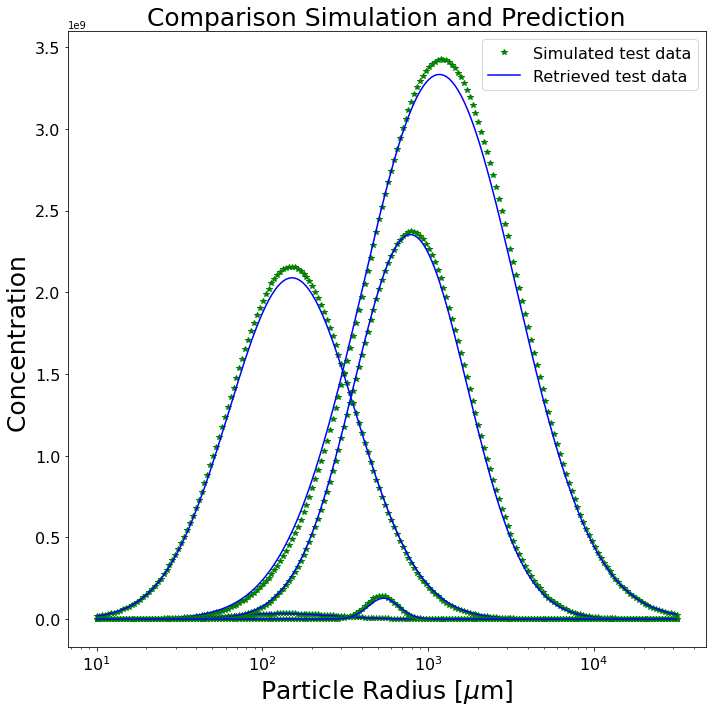

In [32]:
fig, ax = plt.subplots(figsize = (10,10))



for i  in presentation_plot_index:
    
    pdf1 = lognormal(D_array, dvar_test['DmedianN'].loc[i], dvar_test['GSD'].loc[i], dvar_test['Ntot'].loc[i])
    pdf2 = lognormal(D_array, dvar_pred['DmedianN'].loc[i], dvar_pred['GSD'].loc[i], dvar_pred['Ntot'].loc[i])
    
    ax.plot(D_array, pdf1*4/3.*np.pi*D_array**3., '*g', label = 'Simulated test data')
    
    ax.plot(D_array, pdf2*4/3.*np.pi*D_array**3., 'b', label = 'Retrieved test data')
    

    if i == presentation_plot_index[0]:
        ax.legend(['Predicted test data', 'test data'], fontsize = 16)
        ax.legend(fontsize = 16)   

ax.set_xlabel('Particle Radius [$\mu$m]',fontsize = 25)
ax.set_ylabel('Concentration ',fontsize = 25)
ax.tick_params(labelsize = 16)    
ax.set_title( 'Comparison Simulation and Prediction',fontsize = 25)
fig.align_labels()

plt.xscale('log')
#plt.yscale('log')
fig.tight_layout() 
fig.savefig(f'{plot_dir}/size_distribution_true_pred.jpg')

## 3. plot the biggest error 

In [33]:
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [34]:
testGSD1 = rel_error_fw['GSD'].values
testR = rel_error_fw['RmedianV'].values
testn = rel_error_fw['n'].values
testk = rel_error_fw['k'].values
testVtot = rel_error_fw['Vtot'].values
testGSD2 = np.log(dvar_test['RmedianV'].values)
testGSD3 = np.log(dvar_test['GSD'].values)


In [35]:
grid_x, grid_y = np.mgrid[100:5001:1, 1.01:3.1:0.01]

grid_x = np.log(grid_x)
grid_y = np.log(grid_y)
grid_GSD = griddata((testGSD2,testGSD3), testGSD1, (grid_x, grid_y), method='nearest')
grid_R = griddata((testGSD2,testGSD3), testR, (grid_x, grid_y), method='nearest')
grid_Vtot = griddata((testGSD2,testGSD3), testVtot, (grid_x, grid_y), method='nearest')
grid_n = griddata((testGSD2,testGSD3), testn, (grid_x, grid_y), method='nearest')
grid_k = griddata((testGSD2,testGSD3), testk, (grid_x, grid_y), method='nearest')


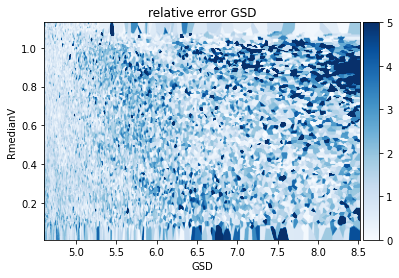

In [36]:
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(grid_GSD.T, extent=(np.log(100),np.log(5000),np.log(1.01),np.log(3.1)),vmin=0, vmax=5,aspect = 'auto',cmap = 'Blues')

ax.set_xlabel('GSD')
ax.set_ylabel('RmedianV')
ax.set_title('relative error GSD')
fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()
fig.savefig(f'{plot_dir}/rel_errGSD_GSD_R.jpg')

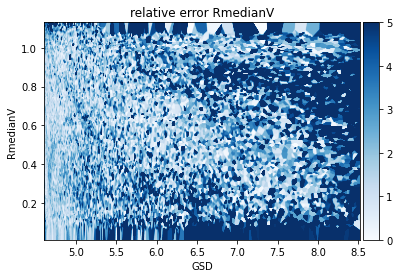

In [37]:
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(grid_R.T, extent=(np.log(100),np.log(5000),np.log(1.01),np.log(3.1)),vmin=0, vmax=5,aspect = 'auto',cmap = 'Blues')
ax.set_xlabel('GSD')
ax.set_ylabel('RmedianV')
ax.set_title('relative error RmedianV')

fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()
fig.savefig(f'{plot_dir}/rel_errR_GSD_R.jpg')

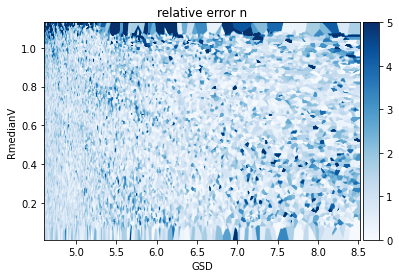

In [38]:
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(grid_n.T, extent=(np.log(100),np.log(5000),np.log(1.01),np.log(3.1)),vmin=0, vmax=5,aspect = 'auto',cmap = 'Blues')

ax.set_xlabel('GSD')
ax.set_ylabel('RmedianV')
ax.set_title('relative error n')

fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()
fig.savefig(f'{plot_dir}/rel_errn_GSD_R.jpg')

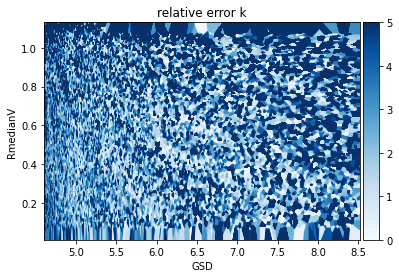

In [39]:
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(grid_k.T, extent=(np.log(100),np.log(5000),np.log(1.01),np.log(3.1)),vmin=0, vmax=5,aspect = 'auto',cmap = 'Blues')
ax.set_xlabel('GSD')
ax.set_ylabel('RmedianV')
ax.set_title('relative error k')

fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()
fig.savefig(f'{plot_dir}/rel_errk_GSD_R.jpg')

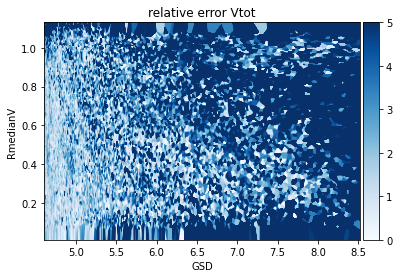

In [40]:
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(grid_Vtot.T, extent=(np.log(100),np.log(5000),np.log(1.01),np.log(3.1)),vmin=0, vmax=5,aspect = 'auto',cmap = 'Blues')

ax.set_xlabel('GSD')
ax.set_ylabel('RmedianV')
ax.set_title('relative error Vtot')

fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()
fig.savefig(f'{plot_dir}/rel_errVtot_GSD_R.jpg')

# Predict phase functions from aerosol properties

In [41]:
qoi_pred = surr_iv.predict(dvar_test_preprocessed)
qoi_pred = pd.DataFrame(data=qoi_pred, columns=qoi_test.columns)

In [42]:
F11_columns = [x for x in qoi_test.columns if 'F11' in x]
PPF_columns = [x for x in qoi_test.columns if 'PPF' in x]

In [43]:
qoi_test[F11_columns] = np.exp(qoi_test[F11_columns])
qoi_pred[F11_columns] = np.exp(qoi_pred[F11_columns])


In [44]:
## 1. calculate metrics

In [45]:
metric = RSquaredSeparated()
r2_adj_iv = metric.call(qoi_test.values, qoi_pred.values).numpy()
r2_adj_iv = pd.Series(data=r2_adj_iv, index=qoi_test.columns)
r2_adj_iv = np.round(r2_adj_iv, decimals=2)
r2_adj_iv = pd.DataFrame(r2_adj_iv).T
print('Forward model: ','R2_min = ', min(r2_adj_iv.min()),';  R2_max = ', max(r2_adj_iv.max()))
r2_adj_iv

Forward model:  R2_min =  0.7 ;  R2_max =  1.0


F11_10  F11_11  F11_12  F11_13  F11_14  F11_15  F11_16  F11_17  F11_18  \
0     1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0   

   F11_19  ...  PPF_161  PPF_162  PPF_163  PPF_164  PPF_165  PPF_166  PPF_167  \
0     1.0  ...     0.76     0.75     0.74     0.74     0.73     0.73     0.73   

   PPF_168  PPF_169  PPF_170  
0     0.73     0.72      0.7  

[1 rows x 304 columns]

In [46]:
iv_error_df = pd.DataFrame(columns = ['F11','PPF'])
iv_error_df.loc['r2']= [np.mean(r2_adj_iv[F11_columns].mean()),np.mean(r2_adj_iv[PPF_columns].mean())]
iv_error_df

F11       PPF
r2  0.999276  0.951579

In [47]:
r2_adj_iv.values

array([[1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 0.99, 0.99,
        0.99, 0.99, 0.99, 0.99, 0.99, 

In [48]:
abs_error_iv = np.abs(qoi_pred - qoi_test)
abs_error_iv

F11_10     F11_11     F11_12      F11_13      F11_14      F11_15  \
0        0.107405   0.140786   0.115242    0.187972    0.216669    0.313408   
1        0.077699   0.054687   0.046012    0.031804    0.025540    0.024853   
2       11.359195  10.074456   6.988099    4.680917    3.223924    1.692227   
3       10.788162   8.940339   6.551146    5.045058    4.347609    3.975070   
4        5.147375  13.048468  24.979338   18.708514    7.881611    6.894966   
...           ...        ...        ...         ...         ...         ...   
19464  247.558935  69.812420  14.064113  149.546863  210.912251  266.640084   
19465    0.241212   0.256653   0.214509    0.005097    0.016130    0.187810   
19466    1.839007   1.454303   0.943584    0.604606    0.429132    0.367860   
19467   56.994896  64.988499  77.131874   76.851681   28.130420    0.483283   
19468    8.684843   7.261280   6.442059    4.401724    3.701386    4.570239   

           F11_16      F11_17      F11_18      F11_19  ...   PPF_161  \
0        0.263813    0.288850    0.332159    0.303721  ...  0.001154   
1        0.021194    0.031872    0.020022    0.019997  ...  0.001283   
2        0.938262    1.533020    1.155597    0.828424  ...  0.005803   
3        3.525145    3.155112    2.817131    2.177392  ...  0.002025   
4        0.319773    0.511953    7.838023    7.133734  ...  0.000279   
...           ...         ...         ...         ...  ...       ...   
19464  238.878065  255.256292  199.953725  182.905069  ...  0.002295   
19465    0.351532    0.528312    0.596837    0.549322  ...  0.006076   
19466    0.163565    0.106118    0.029659    0.016570  ...  0.001385   
19467   15.347995   36.739122   49.232864   50.927690  ...  0.002320   
19468    4.806856    5.269055    4.911785    5.352550  ...  0.003127   

        PPF_162   PPF_163   PPF_164   PPF_165   PPF_166   PPF_167   PPF_168  \
0      0.001074  0.000782  0.000534  0.000172  0.000079  0.000205  0.000592   
1      0.000690  0.001034  0.000761  0.000669  0.000138  0.000131  0.000683   
2      0.008943  0.011264  0.013668  0.014263  0.015624  0.016777  0.017175   
3      0.001733  0.001840  0.002699  0.002490  0.002422  0.002889  0.002675   
4      0.000452  0.000831  0.000520  0.000882  0.000401  0.000435  0.000350   
...         ...       ...       ...       ...       ...       ...       ...   
19464  0.003853  0.003750  0.004543  0.004675  0.004460  0.004579  0.004590   
19465  0.005485  0.003833  0.001883  0.000646  0.000869  0.002779  0.003465   
19466  0.000859  0.001191  0.001932  0.001651  0.001501  0.001701  0.001411   
19467  0.002493  0.002947  0.003910  0.004226  0.004286  0.004496  0.004773   
19468  0.003043  0.003383  0.003797  0.003690  0.003472  0.003187  0.002632   

        PPF_169   PPF_170  
0      0.000460  0.000756  
1      0.000879  0.000348  
2      0.017820  0.014477  
3      0.002945  0.002238  
4      0.000432  0.000224  
...         ...       ...  
19464  0.004363  0.002879  
19465  0.005249  0.004887  
19466  0.001465  0.001026  
19467  0.004672  0.004503  
19468  0.002323  0.001411  

[19469 rows x 304 columns]

In [49]:
abs_error_table_iv =  np.round(abs_error_iv.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)
abs_error_table_iv

F11_10  F11_11  F11_12  F11_13  F11_14  F11_15  F11_16  F11_17  F11_18  \
50%    3.25    2.45    1.85    1.54    1.35    1.23    1.12    1.05    0.94   
75%   29.89   23.51   18.10   15.07   13.26   12.16   11.19   10.45    9.33   
90%  139.36  113.82   93.78   78.80   71.37   68.48   64.70   60.68   55.89   
95%  286.20  238.19  194.73  167.31  154.91  150.32  146.78  141.08  132.07   
99%  821.34  682.47  552.55  476.65  433.45  444.86  435.92  420.23  379.57   

     F11_19  ...  PPF_161  PPF_162  PPF_163  PPF_164  PPF_165  PPF_166  \
50%    0.84  ...     0.00     0.00     0.00     0.00     0.00     0.00   
75%    8.18  ...     0.00     0.00     0.00     0.00     0.00     0.00   
90%   51.45  ...     0.01     0.01     0.01     0.01     0.01     0.01   
95%  121.27  ...     0.01     0.01     0.01     0.01     0.01     0.01   
99%  355.10  ...     0.04     0.04     0.04     0.04     0.04     0.04   

     PPF_167  PPF_168  PPF_169  PPF_170  
50%     0.00     0.00     0.00     0.00  
75%     0.00     0.00     0.00     0.00  
90%     0.01     0.01     0.01     0.00  
95%     0.01     0.01     0.01     0.01  
99%     0.04     0.04     0.03     0.03  

[5 rows x 304 columns]

In [50]:
iv_error_df.loc['abs error 90%']=[abs_error_table_iv[F11_columns].loc['90%'].max(), abs_error_table_iv[PPF_columns].loc['90%'].max()]
iv_error_df.loc['abs error 95%']=[abs_error_table_iv[F11_columns].loc['95%'].max(), abs_error_table_iv[PPF_columns].loc['95%'].max()]


In [51]:
rel_error_iv = abs_error_iv / qoi_test * 100.
rel_error_iv = pd.DataFrame(rel_error_iv, columns=qoi_test.columns).abs()
rel_error_iv

F11_10     F11_11    F11_12    F11_13    F11_14    F11_15    F11_16  \
0       0.538286   0.769980  0.689636  1.233410  1.561421  2.483498  2.300612   
1       0.966897   0.845126  0.870497  0.727333  0.698071  0.803624  0.803195   
2      11.062286  10.036018  7.136442  4.911082  3.482535  1.886144  1.081401   
3       6.151794   5.662378  4.599090  3.917491  3.725933  3.751620  3.655841   
4       0.535256   1.383830  2.704306  2.069307  0.891312  0.797734  0.037873   
...          ...        ...       ...       ...       ...       ...       ...   
19464   3.154485   0.940588  0.200622  2.261047  3.382769  4.539697  4.319515   
19465   2.009391   2.174924  1.852147  0.044911  0.145282  1.731815  3.323841   
19466   5.505327   4.847959  3.500418  2.493604  1.965292  1.868008  0.919516   
19467   0.895329   1.161146  1.559044  1.748698  0.717306  0.013752  0.485480   
19468   3.684479   3.220800  2.987666  2.134324  1.876167  2.421189  2.660883   

         F11_17    F11_18    F11_19  ...    PPF_161    PPF_162    PPF_163  \
0      2.773565  3.512643  3.537347  ...   3.498552   3.528764   2.800733   
1      1.403656  1.016728  1.162422  ...   6.899411   4.051801   6.671639   
2      1.831035  1.433443  1.069522  ...  17.348393  26.609677  34.070546   
3      3.587683  3.504757  2.957427  ...   5.892333   5.467347   6.333375   
4      0.062101  0.974195  0.908866  ...   0.637537   1.149984   2.360881   
...         ...       ...       ...  ...        ...        ...        ...   
19464  4.904141  4.082885  3.970065  ...   3.716855   6.900038   7.473794   
19465  5.130268  5.961495  5.652589  ...  10.395668  10.328419   7.997000   
19466  0.659315  0.203293  0.125065  ...   4.577272   3.058492   4.596454   
19467  1.287105  1.903814  2.166782  ...   6.878427   8.109862  10.587063   
19468  3.046839  2.966018  3.374190  ...   6.287120   6.781289   8.409982   

         PPF_164    PPF_165    PPF_166    PPF_167    PPF_168    PPF_169  \
0       2.101256   0.748719   0.384972   1.129428   3.750172   3.390910   
1       5.418298   5.292525   1.221930   1.307789   7.811584  11.637470   
2      42.848571  47.205638  55.579253  65.327564  74.592742  88.084140   
3      10.205267  10.429354  11.347355  15.301214  16.222154  20.757836   
4       1.664066   3.204194   1.669247   2.093353   1.976283   2.893088   
...          ...        ...        ...        ...        ...        ...   
19464  10.147754  11.798424  12.833887  15.182140  17.746389  19.956630   
19465   4.387143   1.695070   2.593138   9.530325  13.830685  24.742674   
19466   8.142438   7.661299   7.743336   9.870618   9.320620  11.190370   
19467  15.622772  18.934604  21.735464  26.085329  32.075657  36.898283   
19468  10.604489  11.673769  12.555672  13.310136  12.855370  13.453737   

         PPF_170  
0       6.605976  
1       5.419212  
2      83.275141  
3      18.661847  
4       1.815420  
...          ...  
19464  15.847152  
19465  27.685077  
19466   9.223979  
19467  42.517675  
19468   9.856700  

[19469 rows x 304 columns]

In [52]:
rel_error_table_iv = np.round(rel_error_iv.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)
rel_error_table_iv

F11_10  F11_11  F11_12  F11_13  F11_14  F11_15  F11_16  F11_17  F11_18  \
50%    3.35    2.88    2.49    2.33    2.29    2.38    2.42    2.47    2.48   
75%    5.61    4.93    4.34    4.05    3.96    4.00    4.08    4.17    4.21   
90%    8.52    7.51    6.85    6.57    6.37    6.34    6.41    6.52    6.47   
95%   11.76   10.64    9.88    9.27    8.88    8.89    9.22    9.38    9.37   
99%   22.94   24.15   22.99   21.74   20.67   21.65   22.33   24.39   22.97   

     F11_19  ...  PPF_161  PPF_162  PPF_163  PPF_164  PPF_165  PPF_166  \
50%    2.42  ...     6.23     6.92     7.70     9.70    11.08    13.07   
75%    4.10  ...    12.23    13.51    14.60    16.88    18.98    21.82   
90%    6.43  ...    24.05    25.89    27.38    29.88    32.61    35.19   
95%    9.32  ...    39.44    41.30    43.57    45.42    48.31    50.91   
99%   22.20  ...   151.80   154.49   154.46   161.21   161.32   151.71   

     PPF_167  PPF_168  PPF_169  PPF_170  
50%    14.90    17.53    19.03    17.77  
75%    24.21    27.91    31.49    30.69  
90%    39.24    44.45    49.03    49.04  
95%    56.04    59.78    63.86    65.04  
99%   158.68   167.65   167.44   172.51  

[5 rows x 304 columns]

In [53]:
iv_error_df.loc['rel error 90%']=[rel_error_table_iv[F11_columns].loc['90%'].max(), rel_error_table_iv[PPF_columns].loc['90%'].max()]
iv_error_df.loc['rel error 95%']=[rel_error_table_iv[F11_columns].loc['95%'].max(), rel_error_table_iv[PPF_columns].loc['95%'].max()]


In [54]:

abs_error_table_F11 = abs_error_table_iv[F11_columns]
print('Absolute error F11')
print(abs_error_table_F11.max(axis = 1))
abs_error_table_PPF = abs_error_table_iv[PPF_columns]
print('Absolute error PPF')
print(abs_error_table_PPF.max(axis = 1))
rel_error_table_F11 = rel_error_table_iv[F11_columns]
print('Relative error F11')
print(rel_error_table_F11.max(axis = 1))
rel_error_table_PPF = rel_error_table_iv[PPF_columns]
print('Relative error PPF')
print(rel_error_table_PPF.max(axis = 1))


Absolute error F11
50%      3.25
75%     29.89
90%    139.36
95%    286.20
99%    821.34
dtype: float64
Absolute error PPF
50%    0.01
75%    0.01
90%    0.02
95%    0.02
99%    0.08
dtype: float64
Relative error F11
50%     3.35
75%     5.61
90%     8.52
95%    11.76
99%    24.39
dtype: float64
Relative error PPF
50%     19.03
75%     31.49
90%     49.04
95%     74.75
99%    466.66
dtype: float64


In [55]:
wMAPE_qoi = wmape(qoi_test, qoi_pred)
wMAPE_qoi = pd.DataFrame(wMAPE_qoi).T
np.round(wMAPE_qoi, decimals =2)

F11_10  F11_11  F11_12  F11_13  F11_14  F11_15  F11_16  F11_17  F11_18  \
0    4.16     3.8    3.41    3.26     3.2    3.39    3.48    3.59    3.56   

   F11_19  ...  PPF_161  PPF_162  PPF_163  PPF_164  PPF_165  PPF_166  PPF_167  \
0    3.52  ...    11.77     12.7    13.69    15.44    16.81    18.59    20.34   

   PPF_168  PPF_169  PPF_170  
0    22.53    24.43    24.41  

[1 rows x 304 columns]

In [56]:
iv_error_df.loc['wmape']=[wMAPE_qoi[F11_columns].mean().mean(),wMAPE_qoi[PPF_columns].mean().mean()]
iv_error_df

F11        PPF
r2               0.999276   0.951579
abs error 90%  139.360000   0.020000
abs error 95%  286.200000   0.020000
rel error 90%    8.520000  49.040000
rel error 95%   11.760000  74.750000
wmape            2.917373   4.152005

In [57]:
iv_error_df.to_csv(f'{plot_dir}/iv_error_df.csv')

## 2. plots

In [58]:
theta = []
for i in range(10,86):
    theta.append(i)
for i in range(95,171):
    theta.append(i)

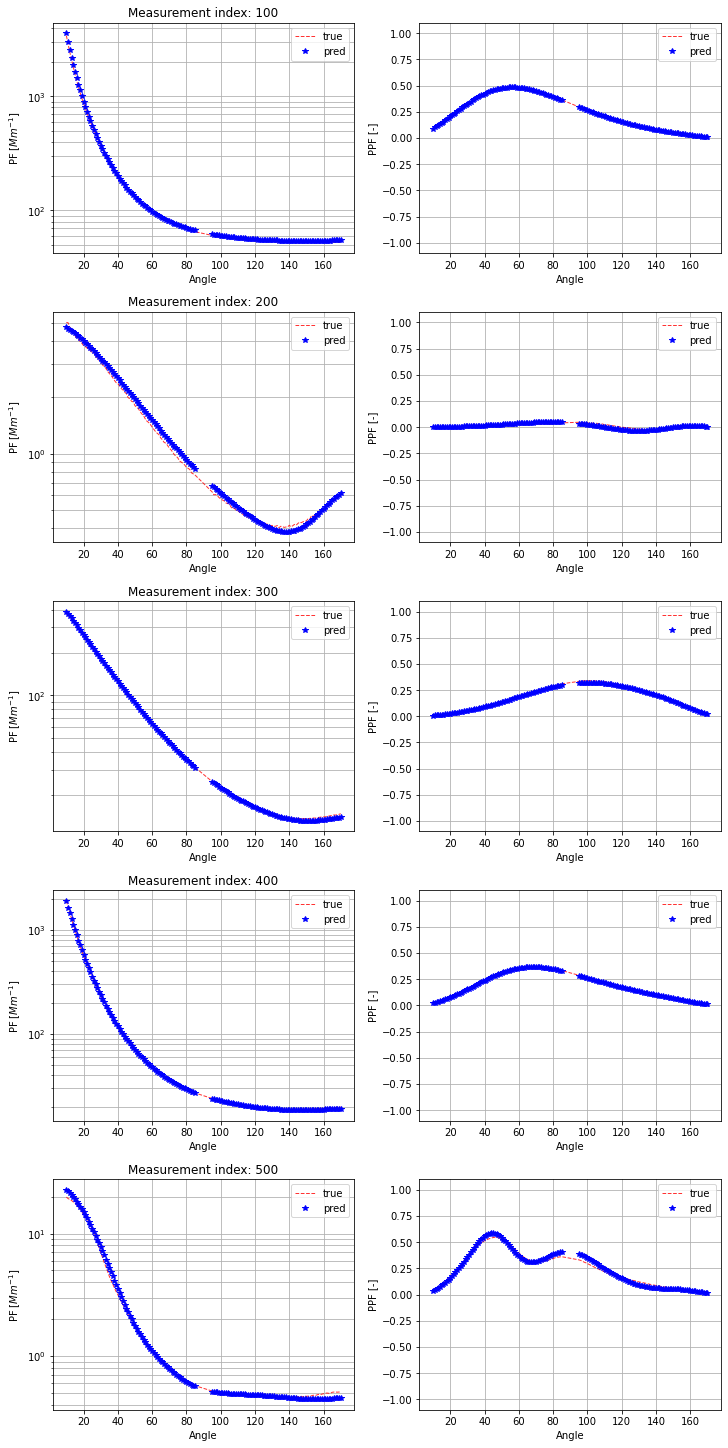

In [59]:
presentation_plot_index = [100,200,300,400,500]
fig, axs = plt.subplots(ncols=2, nrows=5, figsize=(10, 20), constrained_layout=True)
nr = 0
for index in presentation_plot_index:
    axs[nr,0].set_title('Measurement index: '+str(index))

    pms_hdf_plot, = axs[nr,0].plot(theta, qoi_pred[F11_columns].loc[index], ls='--', markersize = 5, lw='1', c='r', alpha=0.8, label='true')
    pms_hdf_plot, = axs[nr,1].plot(theta, qoi_pred[PPF_columns].loc[index], ls='--', lw='1', c='r', alpha=0.8, label='true')

    meas_hdf_plot, = axs[nr,0].plot(theta, qoi_test[F11_columns].loc[index],'*', c= 'b', label = 'pred')
    meas_hdf_plot, = axs[nr,1].plot(theta, qoi_test[PPF_columns].loc[index],'*', c= 'b', label = 'pred')
    

    axs[nr,0].set_ylabel('PF [$Mm^{-1}$]')
    axs[nr,1].set_ylabel('PPF [-]')
    axs[nr,1].set_ylim(-1.1, 1.1)
    axs[nr,0].set_yscale('log')
    for ax in axs.reshape(-1):
        ax.set_xlabel('Angle')
        ax.legend(handles=[pms_hdf_plot,meas_hdf_plot])
        ax.grid(which='both')
    nr = nr+1
fig.savefig(f'{plot_dir}/phase_functions_true_pred.jpg')